In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

In [2]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [3]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 5')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

2120


In [4]:
query[4]

2306

In [5]:
def f(sid):
    sim = SimulatorMagnetic(id=sid)
    dfs = sim.get_data_frames()
    TE = (dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1)
#     print(np.max(np.abs(TE-TE[0]))/TE[0])
    if np.max(np.abs(TE-TE[0]))/TE[0] > 0.5:
        return None
    
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs = sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3).T
    vs = sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3).T
    
    omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
    beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1
    
#     N = sim.particle_number()
#     E = sim.total_energy(sim.r_init, sim.v_init)
#     L = sim.angular_momentum(sim.r_init, sim.v_init)[2].sum()
#     alpha = sim.abc[0]**-1
#     return rs, vs, sim
    return {"omega_MLE" : omega_MLE,
            "beta_MLE" : beta_MLE,
            "N" : sim.particle_number(),
            "L" : sim.angular_momentum(sim.r_init, sim.v_init)[2].sum(),
            "E" : sim.total_energy(sim.r_init, sim.v_init),
            "alpha" : sim.abc[0]**-1
           }

In [6]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count(), maxtasksperchild=1); pool

<multiprocessing.pool.Pool state=RUN pool_size=32>

In [7]:
retult = list(tqdm(pool.imap(f, query[:]), total=len(query)))

  0%|          | 0/2120 [00:00<?, ?it/s]

In [8]:
result = [x for x in retult if x is not None]

In [9]:
df = pd.DataFrame(result)

In [10]:
df["x"] = df.alpha * df.L / df.E
df["y_beta"] = 3 * df.N/df.E/df.beta_MLE
df["y_omega"] = df.omega_MLE * df.L / df.E

In [11]:
def f_beta(x):
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    return np.sqrt(1 + 3 * x**2) - 1

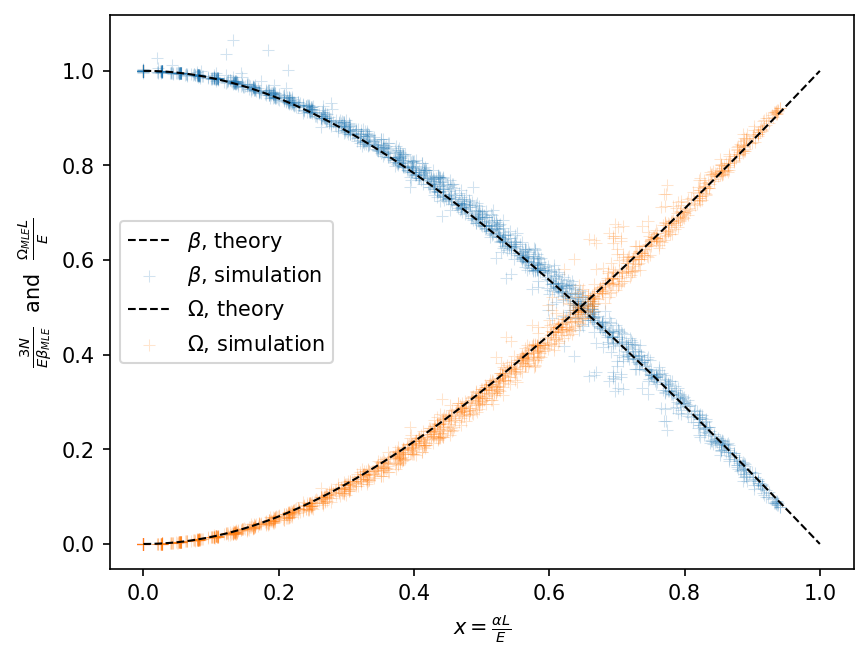

In [21]:
xs = np.linspace(0,1,100)
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=0.2, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=0.2, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [13]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 4')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

160


In [14]:
sims = []
for sid in tqdm(query[:50]):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
data = []
rs = []
vs = []
for sim in tqdm(sims):
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs.append(sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3))
    vs.append(sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [17]:
omega_MLE, beta_MLE

(0.72118163, 5.183027371728906)

In [18]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=4.918682706538689, pvalue=0.08549124095403249)

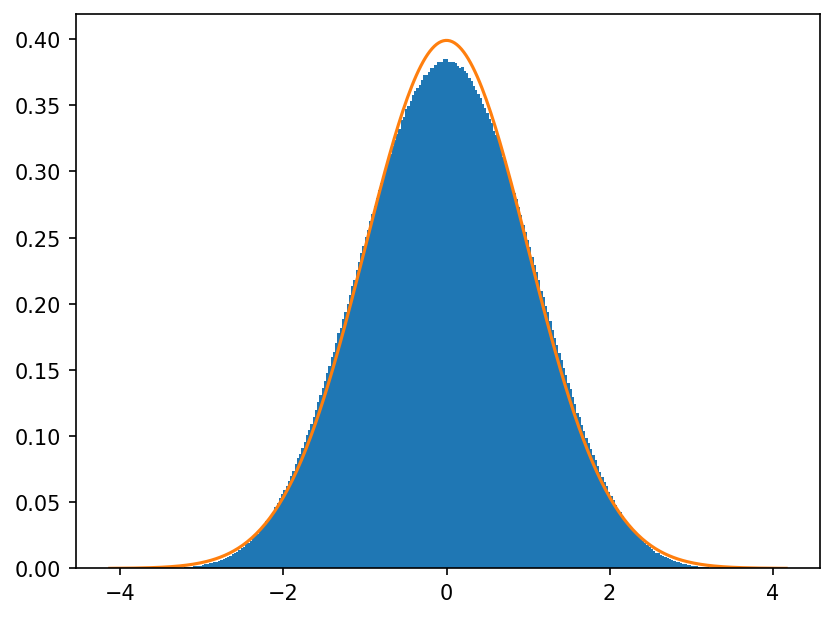

In [19]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

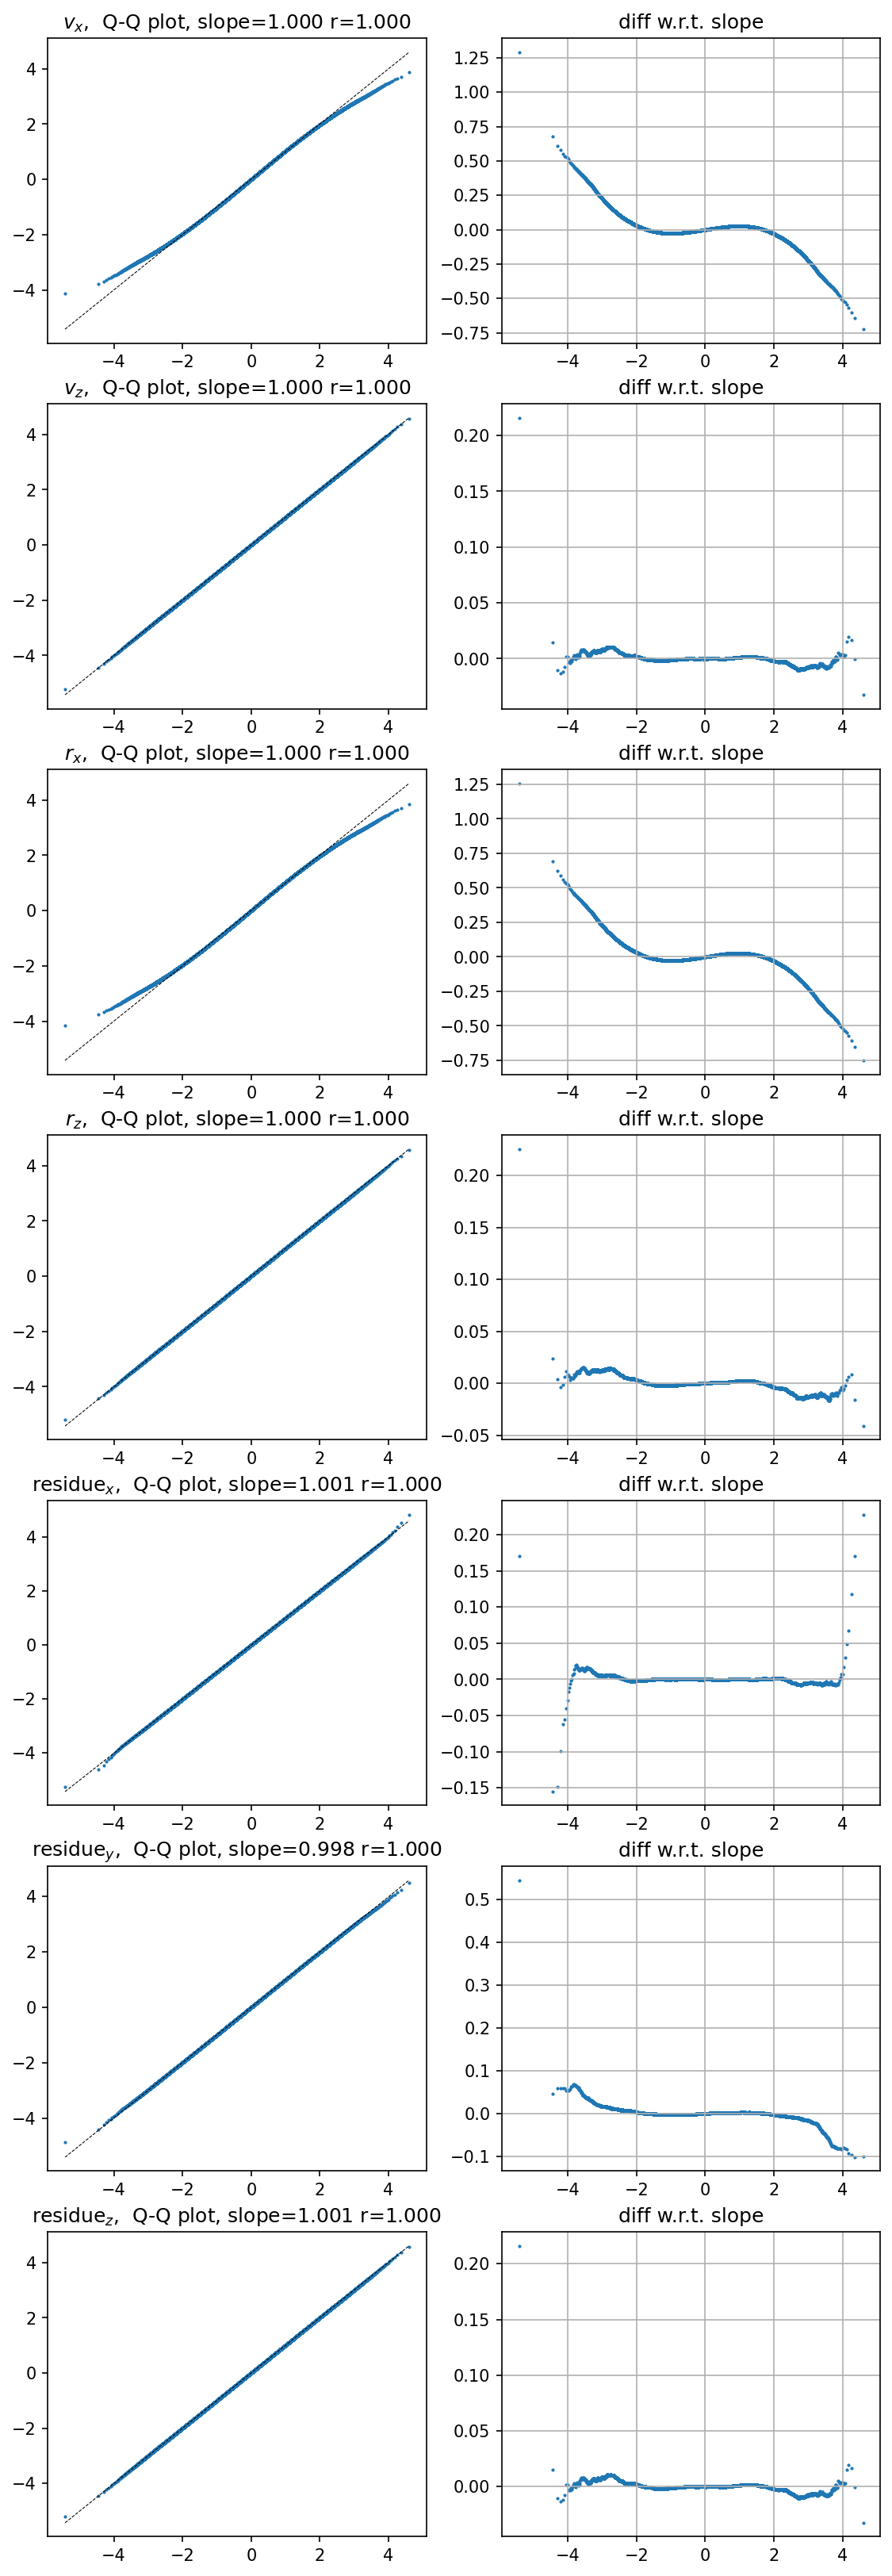

In [20]:
sp=100
plot_data = (
    [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
    ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
)
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2])],
#     ["$v_x$", "$v_z$"]
# )
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)